This jupyter notebooks provides methods and functions for WakeME - custom wake word engine.

Expected Datasets:

/dataset/cv-corpus-6.1-2020-12-11

/dataset/speech_commands_v0.01_full

/dataset/fourthbrain

/dataset/heyfourthbrain

/dataset/hellofourthbrain



# Load relevant libraries

In [ ]:
from google.colab import drive
import pandas as pd
import os
import librosa
import warnings
import numpy as np
import scipy.io.wavfile as wav
import glob
import shutil
import random
import tensorflow as tf
import soundfile as sf
import matplotlib.pyplot as plt
import datetime
warnings.simplefilter("ignore", UserWarning)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve


from IPython.display import Audio
import soundfile

!pip install textgrid
import textgrid

!pip install pydub
from pydub import AudioSegment

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/WakeME_ModelEngine/')

# Define wakeword

In [ ]:
wakeword = 'heyfourthbrain'

# Utility Functions

In [ ]:
'''
function to pick sentences including wakeword candidate from a given source
wake: wake word candidate
dataset_path: summary file path
returns dataframe which includes examples with wakeword
'''

def check_forwake (wake,dataset_path):
  wake = ' '+wake+' '
  dataset = pd.read_table(dataset_path)
  dataset['include'] = dataset['sentence'].apply(lambda x: 'True' if wake.lower() in str(x).lower() else 'False')  
  subset = dataset[dataset['include']=='True']
  subset = subset.reset_index(drop=True)
  #print(len(subset), 'sentences include',wake)
  return subset

## Utility functions for MCV dataset

In [ ]:
'''
convert_2wavlab converts audio files from mp3 to wav format
and creates *lab file for alignment.

used for MCV dataset alignment
'''

def convert_2wavlab(input_df,temp_corpus,num):

  if os.path.isdir(temp_corpus):
    shutil.rmtree(temp_corpus)
  os.makedirs(temp_corpus)

  for row_index in range(min(len(input_df),num)):
    
    file_index = row_index
    path = input_df.iloc[file_index]['path']
    filename = input_df.iloc[file_index]['filename']

    sounddata = librosa.core.load(path, sr=16000, mono=True)[0]
    # convert mp3 to wave
    soundfile.write(f"{temp_corpus}/{filename[:-4]}.wav", sounddata, 16000)
    
    # create lab file 
    f = open(f"{temp_corpus}/{filename[:-4]}.lab", "x")
    f.write(input_df.iloc[file_index]['sentence'])
    f.close()


In [ ]:
'''
convert2wordlevelwav align each word in a sentence, creates single word audio clips from
a full sentence audio clip
'''
def convert2wordlevelwav (corpus_dir,aligned_dir,results_dir,file_tg,only_wake_word=False,wake_word='no_wake_word',padding=False):

    tg = textgrid.TextGrid.fromFile(os.path.join(aligned_dir,file_tg))
    wav_file = file_tg[:-9]+'.wav'
    path_sentence = os.path.join(corpus_dir,wav_file)  
    words_timestamps = {}
    
    for tg_intvl in range(len(tg[0])):
      word = tg[0][tg_intvl].mark
      if word:
        words_timestamps[word] = {'start': tg[0][tg_intvl].minTime, 'end':  tg[0][tg_intvl].maxTime}

    lib_word_sound_map = {}
    sr = 16000
    
    for word, ts in words_timestamps.items():
      audio_start_idx = int((ts['start'] * 1000) * sr / 1000)
      audio_end_idx = int((ts['end'] * 1000) * sr / 1000)
      sounddata = librosa.core.load(path_sentence, sr=16000, mono=True)[0]
      lib_word_sound_map[word] = sounddata[audio_start_idx:audio_end_idx]

    word_list = list(words_timestamps.keys())

    if (only_wake_word == True):
       word_list = [wake_word]

    if not os.path.isdir(results_dir):
       os.makedirs(results_dir)

    for word in word_list:
      path_word = os.path.join(results_dir,word+'_'+wav_file)  
      #print(path_word,wav_file)
      sounddata = lib_word_sound_map[word]
      if (padding==False):
        norm_sounddata = np.linalg.norm(sounddata)
        full_sounddata = sounddata/norm_sounddata * 32767
        full_sounddata = full_sounddata.astype(np.int16)

        wav.write(path_word, 16000, full_sounddata)

      elif ((padding==True) and (sounddata.shape[0] < 16000)):
        zero_padding = np.zeros(16000-sounddata.shape[0])
        full_sounddata = np.concatenate((zero_padding,sounddata),axis=0)*32767
        full_sounddata = full_sounddata.astype(np.int16)

        wav.write(path_word, 16000, full_sounddata)
      elif ((padding==True) and (16000 <sounddata.shape[0] < 24000)):
        zero_padding = np.zeros(24000-sounddata.shape[0])
        full_sounddata = np.concatenate((zero_padding,sounddata),axis=0)*32767
        full_sounddata = full_sounddata.astype(np.int16)
        wav.write(path_word, 24000, full_sounddata)
      else:
         print(word, 'will not be saved, because it is longer than 1.5sec')
      #print('Done')

## Utility functions for negative samples

In [ ]:
'''
check_fornotwake selects audio files which do not include wakeword
used to create negative samples
'''

def check_fornotwake (wake,dataset_path):
  wake = ' '+wake+' '
  dataset = pd.read_table(dataset_path)
  dataset['include'] = dataset['sentence'].apply(lambda x: 'True' if wake.lower() in str(x).lower() else 'False')  
  subset = dataset[dataset['include']=='False']
  subset = subset.reset_index(drop=True)
  #print(len(subset), 'sentences donot include',wake)
  return subset

In [ ]:
'''
convert_mp3towav converts audio files from mp3 to wav format
used to process MCV data set
'''

def convert_mp3towav(input_df,temp_corpus,num):

  if os.path.isdir(temp_corpus):
    shutil.rmtree(temp_corpus)
  os.makedirs(temp_corpus)

  for row_index in range(min(len(input_df),num)):
    #print(row_index)
    file_index = row_index
    path = input_df.iloc[file_index]['path']
    filename = input_df.iloc[file_index]['filename']
    sounddata = librosa.core.load(path, sr=16000, mono=True)[0]
    # convert mp3 to wave
    soundfile.write(f"{temp_corpus}/{filename[:-4]}.wav", sounddata, 16000)


In [ ]:
'''
createchunks converts a wav file into smaller wav files for a given duration. 
The step size when creating smaller audio clips is the duration of wakeword

createchunks_finer converts a wav file into smaller wav files for a given duration. 
The step size when creating smaller audio clips is 0.25 sec

createchunks is used to generate negative samples.
'''

def createchunks (path,duration,sentence_index,temp_neg_dir):
    
    if not os.path.isdir(temp_neg_dir):
       os.makedirs(temp_neg_dir)
    
    sounddata = librosa.core.load(path, sr=16000, mono=True)[0]

    step = 16000*duration
    for i in range(int(len(sounddata)/(step))):

      filename = os.path.join(temp_neg_dir,'negative_'+str(sentence_index)+'_'+str(i)+'.wav')
      start = i*step
      end = start+16000*wake_duration
      chuck = sounddata[int(start):int(end)]
     
      if (chuck.shape[0] < 16000*duration):
            zero_padding = np.zeros(16000*duration-chuck.shape[0])
            chuck = np.concatenate((zero_padding,chuck),axis=0)
      chuck = chuck * 32767
      chuck = chuck.astype(np.int16)

      wav.write(filename, 16000, chuck)


def createchunks_finer (path,duration,sentence_index,temp_neg_dir):
    
    if not os.path.isdir(temp_neg_dir):
       os.makedirs(temp_neg_dir)
    
    sounddata = librosa.core.load(path, sr=16000, mono=True)[0]
    step = 16000/4
    for i in range(int(len(sounddata)/(step))):
      filename = os.path.join(temp_neg_dir,'negative_'+str(sentence_index)+'_'+str(i)+'.wav')
      start = i*step
      end = start+16000*wake_duration
      chuck = sounddata[int(start):int(end)]

      if (chuck.shape[0] < 16000*duration):
            zero_padding = np.zeros(int(16000*duration-chuck.shape[0]))
            chuck = np.concatenate((zero_padding,chuck),axis=0)
      chuck = chuck * 32767
      chuck = chuck.astype(np.int16)
      wav.write(filename, 16000, chuck)

## Utility function for stiching

In [ ]:
'''
stich_wav stiches multuplie wav files into a single wav file

stich_wav is not being used currently.
'''

def stich_wav (final_clip_path,clip_list):
    
    full_sound = []

    for clip in clip_list:
        sounddata = librosa.core.load(clip, sr=16000, mono=True)[0]
        norm_sounddata = np.linalg.norm(sounddata)
        normalized_sounddata = sounddata/norm_sounddata * 32767
        full_sound = np.concatenate((full_sound,normalized_sounddata),axis=0)

    full_sound = full_sound.astype(np.int16)
    wav.write(final_clip_path, 16000, full_sound)

# Create folder for training

In [ ]:
current_training = wakeword+'_'+datetime.datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")

if os.path.isdir(current_training):
  print('training directory already exists')
else:
  os.mkdir(current_training)

# Check if wakeword is included in database

In [ ]:
  database_folder = 'datasets'

  # Check if wakeword is included in database
  sc_validated = database_folder+'/speech_commands_v0.01_full/sc_validated.tsv'
  fourthbrain_validated = database_folder+'/fourthbrain/fourthbrain_validated.txt'
  heyfourthbrain_validated = database_folder+'/heyfourthbrain/heyfourthbrain_validated.txt'
  mcv_validated = database_folder+'/cv-corpus-6.1-2020-12-11/mcv_validated.tsv'
  hellofourthbrain_validated = database_folder+'/hellofourthbrain/hellofourthbrain_validated.txt'

  df_sc = check_forwake (wake=wakeword,dataset_path=sc_validated)
  df_fb = check_forwake (wake=wakeword,dataset_path=fourthbrain_validated)
  df_heyfb = check_forwake (wake=wakeword,dataset_path=heyfourthbrain_validated)
  df_mcv = check_forwake (wake=wakeword,dataset_path=mcv_validated)
  df_hellofb = check_forwake (wake=wakeword,dataset_path=hellofourthbrain_validated)



  if (len(df_sc) > 0):
    use_sc = True
    use_fb = False
    use_heyfb = False
    use_mcv = False
    use_hellofb = False

    print (wakeword,' is  in sc data  set,  model will be provided',len(df_sc))
    num_positive_samples_db = len(df_sc)
  elif (len(df_mcv) > 0):
    use_sc = False
    use_fb = False
    use_heyfb = False
    use_mcv = True
    use_hellofb = False

    print (wakeword,' is  in mcv data  set,  model will be provided')
    num_positive_samples_db = len(df_mcv)

  elif (len(df_fb) > 0):
    use_sc = False
    use_fb = True
    use_heyfb = False
    use_mcv = False
    use_hellofb = False

    print (wakeword,' is  in fb data  set,  model will be provided')
    num_positive_samples_db = len(df_fb)

  elif (len(df_heyfb) > 0):
    use_sc = False
    use_fb = False
    use_heyfb = True
    use_mcv = False
    use_hellofb = False

    print (wakeword,' is  in heyfb data  set,  model will be provided')
    num_positive_samples_db = len(df_heyfb)

  elif (len(df_hellofb) > 0):
    use_sc = False
    use_fb = False
    use_heyfb = False
    use_mcv = False
    use_hellofb = True

    print (wakeword,' is  in hellofb data  set,  model will be provided')
    num_positive_samples_db = len(df_hellofb)

  else:
    print (wakeword,' is not in our training set,  model will not be provided')


heyfourthbrain  is  in heyfb data  set,  model will be provided


# Define some parameter for training

In [ ]:
# Define length of wake word, number of positive and negative samples for training

wake_duration = 1.5 

num_positive_samples = 10 #150 
num_negative_samples = num_positive_samples*3

# Decide if augmentation is needed
if (num_positive_samples > num_positive_samples_db):
  need_aug = True
  aug_size = num_positive_samples - num_positive_samples_db
else:
  need_aug = False



# Create subsets of databases for training

In [ ]:
# clean directories
if os.path.isdir(current_training+'/temp_pos'):
   shutil.rmtree(current_training+'/temp_pos') 
os.makedirs(current_training+'/temp_pos')

if os.path.isdir(current_training+'/temp_neg'):
    shutil.rmtree(current_training+'/temp_neg') 
os.makedirs(current_training+'/temp_neg')

## Make a subset of sc dataset containing wakewords

In [ ]:
if (use_sc == True) and (len(df_sc) > 0):

  sc_files = glob.glob(database_folder+'/speech_commands_v0.01_full/'+wakeword+'/*.wav')
  for i in range(num_positive_samples):
    sounddata = librosa.core.load(sc_files[i], sr=16000, mono=True)[0]
    if (len(sounddata)/16000 < wake_duration) :
        shutil.copy2(sc_files[i], current_training+'/temp_pos/'+sc_files[i].split('/')[-1]) 

## Make a subset of FB dataset containing wakewords [fourthbrain data set]

In [ ]:
if (use_fb == True) and (len(df_fb) > 0):

    fourthbrain_files = glob.glob(database_folder+'/fourthbrain/*.wav')
    for i in range(min(num_positive_samples,len(df_fb))):
      sounddata = librosa.core.load(fourthbrain_files[i], sr=16000, mono=True)[0]
      if (len(sounddata)/16000 < wake_duration) :
        shutil.copy2(fourthbrain_files[i], current_training+'/temp_pos/'+fourthbrain_files[i].split('/')[-1]) 


## Make a subset of hey FB dataset containing wakewords [heyfourthbrain data set]

In [ ]:
if (use_heyfb == True) and (len(df_heyfb) > 0):

  heyfourthbrain_files = glob.glob(database_folder+'/heyfourthbrain/*.wav')
  for i in range(min(num_positive_samples,len(df_heyfb))):
    sounddata = librosa.core.load(heyfourthbrain_files[i], sr=16000, mono=True)[0]
    if (len(sounddata)/16000 < wake_duration) :
       shutil.copy2(heyfourthbrain_files[i], current_training+'/temp_pos/'+heyfourthbrain_files[i].split('/')[-1]) 

## Make a subset of hey FB dataset containing wakewords [hellofourthbrain data set]


In [ ]:
if (use_hellofb == True) and (len(df_hellofb) > 0):

  hellofourthbrain_files = glob.glob(database_folder+'/hellofourthbrain/*.wav')
  for i in range(min(num_positive_samples,len(df_hellofb))):
    sounddata = librosa.core.load(hellofourthbrain_files[i], sr=16000, mono=True)[0]
    if (len(sounddata)/16000 < wake_duration) :
      shutil.copy2(hellofourthbrain_files[i], current_training+'/temp_pos/'+hellofourthbrain_files[i].split('/')[-1]) 

## Make a subset of MCV dataset containing wake words [MozillaDataset] 


In [ ]:
if (use_mcv == True) and (len(df_mcv) > 0):
   convert_2wavlab(input_df=df_mcv,temp_corpus=current_training+'/temp_pos_mcv',num=num_positive_samples)

### Align MCV data

In [ ]:
if (use_mcv == True) and (len(df_mcv) > 0):

  os.chdir(current_training)
  !wget https://github.com/MontrealCorpusTools/Montreal-Forced-Aligner/releases/download/v1.1.0-beta.2/montreal-forced-aligner_linux.tar.gz
  !tar -xf montreal-forced-aligner_linux.tar.gz
  !rm montreal-forced-aligner_linux.tar.gz
  !wget https://www.openslr.org/resources/11/librispeech-lexicon.txt
    
  !montreal-forced-aligner/lib/align temp_pos_mcv librispeech-lexicon.txt montreal-forced-aligner/pretrained_models/english.zip temp_pos_mcv_aligned

  tg_files = [f for f in os.listdir('temp_pos_mcv_aligned') if os.path.isfile(os.path.join('temp_pos_mcv_aligned', f))]
  for tg_file in tg_files:
    if (tg_file != 'unaligned.txt'):
       convert2wordlevelwav(corpus_dir='temp_pos_mcv',aligned_dir='temp_pos_mcv_aligned'
                 ,results_dir='temp_pos', file_tg=tg_file,only_wake_word=True,wake_word=wakeword)


  # Clean temp folders
  if os.path.isdir('temp_pos_mcv'):
     shutil.rmtree('temp_pos_mcv')
  if os.path.isdir('temp_pos_mcv_aligned'):
     shutil.rmtree('temp_pos_mcv_aligned') 
  if os.path.isdir('montreal-forced-aligner'):
    shutil.rmtree('montreal-forced-aligner') 
  if os.path.isfile('librispeech-lexicon.txt'):
    os.remove('librispeech-lexicon.txt') 

  os.chdir('../')



# Create negative examples

In [ ]:
df_neg_mcv = check_fornotwake (wakeword,mcv_validated)
convert_mp3towav(input_df=df_neg_mcv,temp_corpus=current_training+'/temp_neg_mcv',num=num_negative_samples)

for i in range(num_negative_samples):
    createchunks(path=df_neg_mcv.loc[i]['path'],duration=wake_duration, sentence_index=i,temp_neg_dir=current_training+'/temp_neg')

if os.path.isdir(current_training+'/temp_neg_mcv'):
   shutil.rmtree(current_training+'/temp_neg_mcv')    

# Model Training

## Prepare collaterals for model training

### Utility functions

In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_waveform_and_label(filenamelabel):
  label = filenamelabel[1]
  audio_binary = tf.io.read_file(filenamelabel[0])
  waveform = decode_audio(audio_binary)
  zero_padding = tf.zeros([int(float(filenamelabel[2])*16000)] - tf.shape(waveform), dtype=tf.float32)
  waveform = tf.concat([waveform, zero_padding], 0)

  return waveform, label, filenamelabel[2]

'''
Functions for augmentation
'''
def add_normal_noise(wav,noise_level=0.005):
  return wav + noise_level*np.random.normal(0,1,len(wav))
def shift_wave(wav,roll=3):
  return np.roll(wav,int(len(wav)/roll))  
def stretch_wave(wav,factor=0.4):
  return librosa.effects.time_stretch(wav.numpy(),factor)
def pitchshift_wave(wav,shift_steps=-2):
  return librosa.effects.pitch_shift(wav.numpy(),len(wav.numpy()),shift_steps) 


'''
get_spectrograms takes the waveform and applt STFT, and returns spectrogram
'''

def get_spectrogram(waveform):
  # Padding for files with less than 3200 samples
  duration=1.5
  zero_padding = tf.zeros([int(duration*16000)] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 

  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=64)
  spectrogram = tf.abs(spectrogram)

  return spectrogram

def get_spectrogram_and_label_id(audio, label, duration):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == ['positive','negative'])
  return spectrogram, label_id, float(duration)

def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds  

#### Functions for displaying

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

### Data prep

In [ ]:
# Read names of negative and positive samples

neg_samples = glob.glob(current_training+'/temp_neg/*.wav')
pos_samples = glob.glob(current_training+'/temp_pos/*.wav')


filenamelabels_neg_samples = []
for i in range(len(neg_samples)):
  filenamelabels_neg_samples.append([neg_samples[i],'negative',str(wake_duration)])

filenamelabels_pos_samples = []

for i in range(len(pos_samples)):
  filenamelabels_pos_samples.append([pos_samples[i],'positive',str(wake_duration)])


filenamelabels_neg_samples = filenamelabels_neg_samples[0:num_negative_samples]

if (len(filenamelabels_pos_samples) > num_negative_samples):
  filenamelabels_pos_samples = filenamelabels_pos_samples[0:filenamelabels_pos_samples]

print(len(filenamelabels_neg_samples),len(filenamelabels_pos_samples))

30 9


In [ ]:
# Create additional training samples

pos_train_files_aug = []

if (need_aug == True):
  for i in range(int(aug_size/4)):
      #print(i,train_files[i])
      j = i%10
      waveform, label,_ = get_waveform_and_label(filenamelabels_pos_samples[j])
      if (label == 'positive'):
        noise_wav = add_normal_noise(waveform)
        shifted_wav = shift_wave(waveform)
        lowpitch_wav = pitchshift_wave(waveform,shift_steps=-2)
        highpitch_wav = pitchshift_wave(waveform,shift_steps=2)
          
        filepath, label, _ = filenamelabels_pos_samples[j]
        filename = filepath.split('/')[-1].split('.')[0]

        filename_noise = os.path.join(current_training,'temp_pos',filename+str(i)+'_noise''.wav')
        filename_shifted = os.path.join(current_training,'temp_pos',filename+str(i)+'_shifted'+'.wav')
        filename_lowpitch = os.path.join(current_training,'temp_pos',filename+str(i)+'_lowpitch'+'.wav')
        filename_highpitch = os.path.join(current_training,'temp_pos',filename+str(i)+'_highpitch'+'.wav')

        sf.write(filename_noise,noise_wav,16000)
        sf.write(filename_shifted,shifted_wav,16000)
        sf.write(filename_lowpitch,lowpitch_wav,16000)
        sf.write(filename_highpitch,highpitch_wav,16000)
          
        pos_train_files_aug.append([filename_noise,label,str(wake_duration)])
        pos_train_files_aug.append([filename_shifted,label,str(wake_duration)])
        pos_train_files_aug.append([filename_lowpitch,label,str(wake_duration)])
        pos_train_files_aug.append([filename_highpitch,label,str(wake_duration)])
    
filenamelabels_pos_samples = filenamelabels_pos_samples+pos_train_files_aug

In [ ]:

# Split data set for train/test/val

filenamelabels = filenamelabels_pos_samples + filenamelabels_neg_samples
random.Random(4).shuffle(filenamelabels)

print(len(filenamelabels))

full_size = len(filenamelabels)
train_size = int(0.75*full_size)
val_size = int(0.10*full_size)

train_files = filenamelabels[:train_size]
val_files = filenamelabels[train_size: train_size + val_size]
test_files = filenamelabels[len(train_files)+len(val_files):]

print(len(train_files),len(val_files),len(test_files))

39
29 3 7


### Read data using tf

In [ ]:
train_files = tf.random.shuffle(train_files,seed=2)
val_files = tf.random.shuffle(val_files,seed=2)
test_files = tf.random.shuffle(test_files,seed=2)
AUTOTUNE = tf.data.AUTOTUNE
files_train = tf.data.Dataset.from_tensor_slices(train_files)
waveform_train = files_train.map(get_waveform_and_label,num_parallel_calls=AUTOTUNE)

### Debug check

In [ ]:
debug_mode = False

In [ ]:
if (debug_mode == True):
  rows = 4
  cols = 4
  n = rows*cols
  fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
  for i, (audio, label,_) in enumerate(waveform_train.take(n)):
    #print(audio.numpy())
    #print(label)
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

  plt.show() 

In [ ]:
if (debug_mode==True):
  for waveform, label,_ in waveform_train.take(12):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)

  fig, axes = plt.subplots(2, figsize=(12, 8))
  timescale = np.arange(waveform.shape[0])
  axes[0].plot(timescale, waveform.numpy())
  axes[0].set_title('Waveform')
  axes[0].set_xlim([0, 48000])
  plot_spectrogram(spectrogram.numpy(), axes[1])
  axes[1].set_title('Spectrogram')
  plt.show()


## Helper functions for model eval

In [ ]:
def print_loss_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, color='red', label='Training loss')
    plt.plot(epochs, val_loss, color='green', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return

def print_accuracy_history(training_history):
    acc = training_history.history['accuracy']
    val_acc = training_history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, color='red', label='Training acc')
    plt.plot(epochs, val_acc, color='green', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    return

def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='plasma')
            activation_index += 1   
    return


def display_modelmetrics(test_ds, model,threshold=0.5): 
  test_audio = []
  test_labels = []

  for audio, label, _ in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

  test_audio = np.array(test_audio)
  test_labels = np.array(test_labels)
  y_pred = []
  y_prob = []
  for i in range(len(test_audio)):
      y_prob.append(model.predict(test_audio)[i][0])
      if (threshold < model.predict(test_audio)[i][0]):
        y_pred.append(1)
      else:
        y_pred.append(0)

  y_true = test_labels

  test_acc = sum(y_pred == y_true) / len(y_true)

  print(f'Accuracy = {accuracy_score(y_true, y_pred)}')
  print(f'F1 = {f1_score(y_true, y_pred)}')
  print(f'Precision = {precision_score(y_true, y_pred)}')
  print(f'Recall = {recall_score(y_true, y_pred)}')
  print('Confusion matrix =')
  print(confusion_matrix(y_true, y_pred))


  fpr, tpr, thresholds = roc_curve(y_true, y_prob)
  # plot the roc curve for the model
  plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
  plt.plot(fpr, tpr, marker='.', label='ML')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend()
  plt.show()

  return   y_true,y_pred,y_prob

## Prepare dataset for batching,training...

In [ ]:
# Preproc data sets
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

train_ds_test = preprocess_dataset(train_files)

# Batch data sets
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

# Cache
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)


# Get input shape of images

spectrogram_train = waveform_train.map(
      get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

for spectrogram,_,_ in spectrogram_train.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)

Input shape: (372, 129, 1)


## Custom CNN

### Initialize model

In [ ]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_train.map(lambda x, _, __: x))

model1 = models.Sequential([
      layers.Input(shape=input_shape),
      preprocessing.Resizing(32, 32), 
      norm_layer,
      layers.Conv2D(32, 3, activation='relu'),
      layers.Conv2D(64, 3, activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.25),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(1,activation='sigmoid'),
])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

###Compile model

In [ ]:
lr, num_epochs = 0.001, 200

optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

model1.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

### Train model

In [ ]:
history_model1 = model1.fit(
      train_ds, 
      validation_data=val_ds,  
      epochs=num_epochs,
      callbacks=tf.keras.callbacks.EarlyStopping(verbose=0, patience=6)
      )

Epoch 1/200
1/1 [==============================] - 17s 17s/step - loss: 1.0277 - accuracy: 0.6207 - val_loss: 1.0640 - val_accuracy: 0.3333
Epoch 2/200
1/1 [==============================] - 0s 42ms/step - loss: 1.0152 - accuracy: 0.6207 - val_loss: 1.0638 - val_accuracy: 0.3333
Epoch 3/200
1/1 [==============================] - 0s 39ms/step - loss: 0.9735 - accuracy: 0.7241 - val_loss: 1.0654 - val_accuracy: 0.3333
Epoch 4/200
1/1 [==============================] - 0s 40ms/step - loss: 1.0818 - accuracy: 0.4483 - val_loss: 1.0682 - val_accuracy: 0.3333
Epoch 5/200
1/1 [==============================] - 0s 39ms/step - loss: 1.0118 - accuracy: 0.6552 - val_loss: 1.0688 - val_accuracy: 0.3333
Epoch 6/200
1/1 [==============================] - 0s 38ms/step - loss: 1.0113 - accuracy: 0.6897 - val_loss: 1.0702 - val_accuracy: 0.3333
Epoch 7/200
1/1 [==============================] - 0s 37ms/step - loss: 1.0241 - accuracy: 0.6207 - val_loss: 1.0712 - val_accuracy: 0.3333
Epoch 8/200
1/1 [===

### Evaluate model

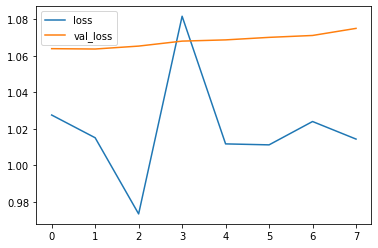

Accuracy = 0.7142857142857143
F1 = 0.8333333333333333
Precision = 0.7142857142857143
Recall = 1.0
Confusion matrix =
[[0 2]
 [0 5]]


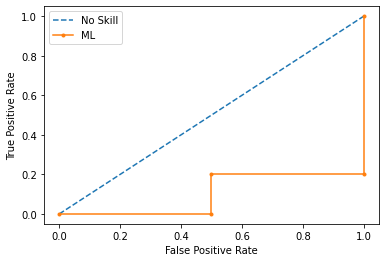

INFO:tensorflow:Assets written to: heyfourthbrain_2021_09_12-06_29_44_AM/model1/heyfourthbrain/assets


In [ ]:
model1_folder = current_training +'/model1'
model1_results = model1_folder +'/'+wakeword+'_model1_results.txt'
model1_path = model1_folder +'/'+wakeword

if os.path.isdir(model1_folder):
    shutil.rmtree(model1_folder)
os.mkdir(model1_folder)
  
metrics = history_model1.history
plt.plot(history_model1.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
  
y_true,y_pred,y_prob = display_modelmetrics(test_ds=test_ds, model=model1)

data = {'Accuracy':  [accuracy_score(y_true, y_pred)],
          'F1score': [f1_score(y_true, y_pred)],
          'Precision': [precision_score(y_true, y_pred)],
          'Recall': [recall_score(y_true, y_pred)],
          'lr': [lr],
          'num_epoch': [num_epochs],
          'num_neg': [len(filenamelabels_neg_samples)],
          'num_pos': [len(filenamelabels_pos_samples)]
          }

df_metrics = pd.DataFrame (data, columns = ['Accuracy','F1score','Precision','Recall','lr','num_epoch','num_neg','num_pos'])

df_metrics.to_csv(model1_results,sep='\t',index=False)
tf.keras.models.save_model(model1, model1_path)

## Resnet8

### Model Definition

In [ ]:
  class Residual(tf.keras.Model): 
      """The Residual block of ResNet."""
      def __init__(self, num_channels, use_1x1conv=False, strides=1):
          super().__init__()
          self.conv1 = tf.keras.layers.Conv2D(num_channels, padding='same',
                                              kernel_size=3, strides=strides)
          self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                              padding='same')
          self.conv3 = None
          if use_1x1conv:
              self.conv3 = tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                                                  strides=strides)
          self.bn1 = tf.keras.layers.BatchNormalization()
          self.bn2 = tf.keras.layers.BatchNormalization()

      def call(self, X):
      #   Y = tf.keras.activations.relu(self.bn1(self.conv1(X))) 
      #   Y = self.bn2(self.conv2(Y))
          Y = self.conv1(X)
          Y = self.bn1(Y)      
          Y = tf.keras.activations.relu(Y)        
          Y = self.conv2(Y)
          Y = self.bn2(Y)
          if self.conv3 is not None:
              X = self.conv3(X)
          Y += X
      
          return tf.keras.activations.relu(Y)

  class ResnetBlock(tf.keras.layers.Layer):
      def __init__(self, num_channels, num_residuals, first_block=False,
                  **kwargs):
          super(ResnetBlock, self).__init__(**kwargs)
          self.residual_layers = []
          #print('number of residual',num_residuals)
          for i in range(num_residuals):
              if i == 0 and not first_block:
                  self.residual_layers.append(Residual(num_channels, use_1x1conv=True, strides=2))
              else:
                  self.residual_layers.append(Residual(num_channels))

      def call(self, X):
          for layer in self.residual_layers.layers:
              X = layer(X)
          return X
  def net():
      return tf.keras.Sequential([
          # The following layers are the same as b1 that we created earlier
          tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Activation('relu'),
          tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'),
          # The following layers are the same as b2, b3, b4, and b5 that we
          # created earlier
          ResnetBlock(64, 2, first_block=True),
          ResnetBlock(128, 2),
          ResnetBlock(256, 2),
          ResnetBlock(512, 2),
          tf.keras.layers.GlobalAvgPool2D(),
          tf.keras.layers.Dense(units=1,activation='sigmoid')])      
          #tf.keras.layers.Dense(units=2)])      


### Initialize model

In [ ]:
lr, num_epochs  = 0.001, 200 

optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

model2 = net()
model2.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

### Train model

In [ ]:
history_model2 = model2.fit(
      train_ds, 
      validation_data=val_ds,  
      epochs=num_epochs,
      callbacks=tf.keras.callbacks.EarlyStopping(verbose=0, patience=6)
      )

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 1.8686 - accuracy: 0.1724 - val_loss: 1.0320 - val_accuracy: 0.6667
Epoch 2/200
1/1 [==============================] - 0s 155ms/step - loss: 1.5680 - accuracy: 0.1724 - val_loss: 1.0322 - val_accuracy: 0.6667
Epoch 3/200
1/1 [==============================] - 0s 151ms/step - loss: 1.3279 - accuracy: 0.1724 - val_loss: 1.0325 - val_accuracy: 0.6667
Epoch 4/200
1/1 [==============================] - 0s 146ms/step - loss: 1.1371 - accuracy: 0.1724 - val_loss: 1.0330 - val_accuracy: 0.6667
Epoch 5/200
1/1 [==============================] - 0s 151ms/step - loss: 0.9868 - accuracy: 0.4828 - val_loss: 1.0338 - val_accuracy: 0.6667
Epoch 6/200
1/1 [==============================] - 0s 150ms/step - loss: 0.8687 - accuracy: 0.7586 - val_loss: 1.0349 - val_accuracy: 0.6667
Epoch 7/200
1/1 [==============================] - 0s 152ms/step - loss: 0.7740 - accuracy: 0.9310 - val_loss: 1.0361 - val_accuracy: 0.6667


### Evaluate model

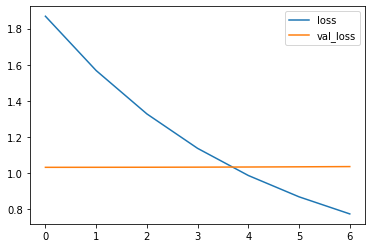

Accuracy = 0.5714285714285714
F1 = 0.6666666666666665
Precision = 0.75
Recall = 0.6
Confusion matrix =
[[1 1]
 [2 3]]


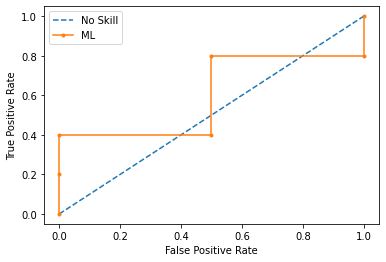

INFO:tensorflow:Assets written to: heyfourthbrain_2021_09_12-06_29_44_AM/model2/heyfourthbrain/assets


In [ ]:
metrics = history_model2.history
plt.plot(history_model2.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()
  
y_true,y_pred,y_prob = display_modelmetrics(test_ds=test_ds, model=model2)
  
model2_folder = current_training +'/model2'
model2_path = model2_folder +'/'+wakeword
model2_results = model2_folder +'/'+wakeword+'_model2_results.txt'

if os.path.isdir(model2_folder):
    shutil.rmtree(model2_folder)
os.mkdir(model2_folder)

data = {'Accuracy':  [accuracy_score(y_true, y_pred)],
          'F1score': [f1_score(y_true, y_pred)],
          'Precision': [precision_score(y_true, y_pred)],
          'Recall': [recall_score(y_true, y_pred)],
          'lr': [lr],
          'num_epoch': [num_epochs],
          'num_neg': [len(filenamelabels_neg_samples)],
          'num_pos': [len(filenamelabels_pos_samples)]
          }

df_metrics = pd.DataFrame (data, columns = ['Accuracy','F1score','Precision','Recall','lr','num_epoch','num_neg','num_pos'])

df_metrics.to_csv(model2_results,sep='\t',index=False)
 
tf.keras.models.save_model(model2, model2_path)

## AlexNet

### Model Definition

In [ ]:
# Define the AlexNet model
# Model Definition
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
      super().__init__()

      self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                      padding= 'valid', activation= 'relu',
                      input_shape= input_shape, kernel_initializer= 'he_normal'))
      self.add(BatchNormalization())
      self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                            padding= 'valid', data_format= None))
      
      
      self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                      padding= 'same', activation= 'relu',
                      kernel_initializer= 'he_normal'))
      self.add(BatchNormalization())
      self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                            padding= 'valid', data_format= None)) 
      

      self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                      padding= 'same', activation= 'relu',
                      kernel_initializer= 'he_normal'))
      self.add(BatchNormalization())
      
      self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                      padding= 'same', activation= 'relu',
                      kernel_initializer= 'he_normal'))
      self.add(BatchNormalization())
      
      self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                      padding= 'same', activation= 'relu',
                      kernel_initializer= 'he_normal'))
      self.add(BatchNormalization())
      
      self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                            padding= 'valid', data_format= None))
      

      self.add(Flatten())
      #self.add(layers.Dense(10, activation='relu'))

      self.add(layers.Dense(1, activation='sigmoid'))    
      #self.add(Dense(num_classes, activation= 'softmax'))


### Initialize model

In [ ]:
model3 = AlexNet((input_shape[0],input_shape[1],1),num_classes=1)
model3.summary()

Model: "alex_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 91, 30, 96)        11712     
_________________________________________________________________
batch_normalization_22 (Batc (None, 91, 30, 96)        384       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 45, 14, 96)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 45, 14, 256)       614656    
_________________________________________________________________
batch_normalization_23 (Batc (None, 45, 14, 256)       1024      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 6, 256)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 22, 6, 384)        8

In [ ]:
lr, num_epochs  = 0.001, 200

optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
model3.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### Train Model

In [ ]:
history_model3 = model3.fit(
      train_ds, 
      validation_data=val_ds,  
      epochs=num_epochs,
      callbacks=tf.keras.callbacks.EarlyStopping(verbose=0, patience=6)
      )

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 1.7324 - accuracy: 0.6207 - val_loss: 1.9441 - val_accuracy: 0.6667
Epoch 2/200
1/1 [==============================] - 0s 68ms/step - loss: 0.2411 - accuracy: 0.9655 - val_loss: 1.1906 - val_accuracy: 0.6667
Epoch 3/200
1/1 [==============================] - 0s 66ms/step - loss: 0.0352 - accuracy: 1.0000 - val_loss: 1.1606 - val_accuracy: 0.6667
Epoch 4/200
1/1 [==============================] - 0s 67ms/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 1.1357 - val_accuracy: 0.6667
Epoch 5/200
1/1 [==============================] - 0s 69ms/step - loss: 0.0252 - accuracy: 1.0000 - val_loss: 1.1102 - val_accuracy: 0.6667
Epoch 6/200
1/1 [==============================] - 0s 67ms/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 1.0859 - val_accuracy: 0.6667
Epoch 7/200
1/1 [==============================] - 0s 66ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 1.0624 - val_accuracy: 0.6667
Epoch 8/200
1/1 [=====

### Evaluate model

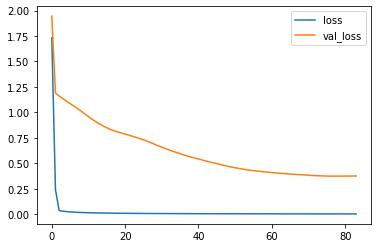

Accuracy = 0.8571428571428571
F1 = 0.9090909090909091
Precision = 0.8333333333333334
Recall = 1.0
Confusion matrix =
[[1 1]
 [0 5]]


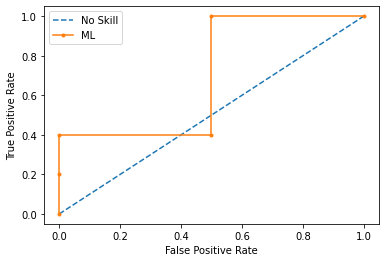

INFO:tensorflow:Assets written to: heyfourthbrain_2021_09_12-06_29_44_AM/model3/heyfourthbrain/assets


In [ ]:
metrics = history_model3.history
plt.plot(history_model3.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

y_true,y_pred,y_prob = display_modelmetrics(test_ds=test_ds, model=model3)

### Save model
model3_folder = current_training +'/model3'
model3_path = model3_folder +'/'+wakeword
model3_results = model3_folder +'/'+wakeword+'_model3_results.txt'

if os.path.isdir(model3_folder):
    shutil.rmtree(model3_folder)
os.mkdir(model3_folder)

data = {'Accuracy':  [accuracy_score(y_true, y_pred)],
          'F1score': [f1_score(y_true, y_pred)],
          'Precision': [precision_score(y_true, y_pred)],
          'Recall': [recall_score(y_true, y_pred)],
          'lr': [lr],
          'num_epoch': [num_epochs],
          'num_neg': [len(filenamelabels_neg_samples)],
          'num_pos': [len(filenamelabels_pos_samples)]
          }

df_metrics = pd.DataFrame (data, columns = ['Accuracy','F1score','Precision','Recall','lr','num_epoch','num_neg','num_pos'])

df_metrics.to_csv(model3_results,sep='\t',index=False)
  
tf.keras.models.save_model(model3, model3_path)

# Model Eval - FP rate

In [ ]:
  mcv_negtest = database_folder+'/cv-corpus-6.1-2020-12-11/mcv_negtest.tsv'

  df_neg_mcv = check_fornotwake (wakeword,mcv_negtest)
  convert_mp3towav(input_df=df_neg_mcv,temp_corpus=current_training+'/temp_neg_test_mcv',num=250)
  for i in range(250):
      createchunks(path=df_neg_mcv.loc[i]['path'],duration=wake_duration, sentence_index=i,temp_neg_dir=current_training+'/temp_neg_test_clips')
  
  ## Helper function for short clip tests 
  def test_short_clips(samples_list,model,num=500):
    y_pred = []

    for i in range(len(samples_list[0:min(num,len(samples_list))])):
      test = samples_list[i]
      #print(test)
      test_example = [[test,'test','1.5']]

      test_example = tf.random.shuffle(test_example,seed=2)
      test_example_ds = preprocess_dataset(test_example)

      test_example_audio = []
      test_example_labels = []

      for audio, label, _ in test_example_ds:
        test_example_audio.append(audio.numpy())
        test_example_labels.append(label.numpy())

      test_example_audio = np.array(test_example_audio)
      test_example_labels = np.array(test_example_labels)


      if (0.5 < model.predict(test_example_audio)[0][0]):
        y_pred.append(1)
      else:
        y_pred.append(0)


## Create more negative samples for FP test

In [ ]:
mcv_negtest = database_folder+'/cv-corpus-6.1-2020-12-11/mcv_negtest.tsv'
N = 10
df_neg_mcv = check_fornotwake (wakeword,mcv_negtest)
convert_mp3towav(input_df=df_neg_mcv,temp_corpus=current_training+'/temp_neg_test_mcv',num=N)
for i in range(N):
   createchunks(path=df_neg_mcv.loc[i]['path'],duration=wake_duration, sentence_index=i,temp_neg_dir=current_training+'/temp_neg_test_clips')
  

## Helper function for short clip tests 

In [ ]:
  def test_short_clips(samples_list,model,num=500):
    y_pred = []

    for i in range(len(samples_list[0:min(num,len(samples_list))])):
      test = samples_list[i]
      #print(test)
      test_example = [[test,'test','1.5']]

      test_example = tf.random.shuffle(test_example,seed=2)
      test_example_ds = preprocess_dataset(test_example)

      test_example_audio = []
      test_example_labels = []

      for audio, label, _ in test_example_ds:
        test_example_audio.append(audio.numpy())
        test_example_labels.append(label.numpy())

      test_example_audio = np.array(test_example_audio)
      test_example_labels = np.array(test_example_labels)


      if (0.5 < model.predict(test_example_audio)[0][0]):
        y_pred.append(1)
      else:
        y_pred.append(0)


    #print('negative identification',sum(y_pred))
    #print('positive identification',len(y_pred)-sum(y_pred))
    #print('total number of samples',len(y_pred))

    return y_pred

## Evaluate models for false positive using shortclips

In [ ]:
test_neg_test_clips = glob.glob(current_training+'/temp_neg_test_clips/*.wav')
num_clips = int(10*60/wake_duration)
length = num_clips*wake_duration/60

#print(num_clips,length)
y_pred_1 = test_short_clips(samples_list=test_neg_test_clips,model=model1,num=num_clips)
y_pred_2 = test_short_clips(samples_list=test_neg_test_clips,model=model2,num=num_clips)
y_pred_3 = test_short_clips(samples_list=test_neg_test_clips,model=model3,num=num_clips)

fp_model1 = 100*(len(y_pred_1)-sum(y_pred_1))/len(y_pred_1)
fp_model2 = 100*(len(y_pred_2)-sum(y_pred_2))/len(y_pred_2)
fp_model3 = 100*(len(y_pred_3)-sum(y_pred_3))/len(y_pred_3)

#print(fp_model1,fp_model2,fp_model3)

data = {'FP_Rate(%)':  [fp_model1,fp_model2,fp_model3],
          'Model': ['custom_cnn','ResNet8','AlexNet'],
          'NumClips': [num_clips,num_clips,num_clips],
          'Length(min)': [length,length,length]
          }

df_fp = pd.DataFrame (data, columns = ['Model','FP_Rate(%)','NumClips','Length(min)'])

fp_metrics_path = current_training+'/comparison_fp_shortnegative_clips.txt'

df_fp.to_csv(fp_metrics_path,sep='\t',index=False)

##Stich Negative Sentences

In [ ]:
neg_test_samples = glob.glob(current_training+'/temp_neg_test_mcv/*.wav')
length_cont_stream = 15

long_data_negtest = []
for file_index in range(len(neg_test_samples)):
    path = neg_test_samples[file_index]
    sounddata = librosa.core.load(path, sr=16000, mono=True)[0]
    long_data_negtest = np.concatenate((long_data_negtest,sounddata),axis=0)
    if (len(long_data_negtest) > int(length_cont_stream*60*16000)):
       print(len(long_data_negtest),file_index)
       break
  
long_data_negtest = long_data_negtest [0:int(length_cont_stream*60*16000)]
long_data_negtest = long_data_negtest * 32767
long_data_negtest = long_data_negtest.astype(np.int16)
long_data_negtest_path = current_training+'/long_neg_test.wav'
wav.write(long_data_negtest_path, 16000, long_data_negtest)
sounddata = librosa.core.load(long_data_negtest_path, sr=16000, mono=True)[0]
 
#print('total_min',len(sounddata)/16000/60)
Audio(sounddata,rate=16000)

## Helper function for full negative test

In [ ]:
  def test_long_negative_clip (path,model,step=int(16000/2)):

    sounddata = librosa.core.load(path, sr=16000, mono=True)[0]
    length = len(sounddata)/16000/60
    frame_step = wake_duration*16000
    y_pred = []
    y_pos_clips = []

    for start in range(0,int(len(sounddata)),step):
      end = start+frame_step
      #print(start,end)
      spec = get_spectrogram(sounddata[start:int(min(end,len(sounddata)))])
      spec = np.array(spec)
      spec = spec.reshape(1,spec.shape[0],spec.shape[1],1)
      
      if (0.5 < model.predict(spec)):
          y_pred.append(1)
      else:
          y_pred.append(0)
          pos_clip = sounddata[start:int(min(end,len(sounddata)))]
          y_pos_clips.append(pos_clip)

    #print('negative identification',sum(y_pred))
    #print('positive identification',len(y_pred)-sum(y_pred))
    #print('totalnumsample',len(y_pred))
    #print('false positive rate %',100*(len(y_pred)-sum(y_pred))/len(y_pred))

    #plt.scatter(np.linspace(0,int(len(sounddata)/16000/60),len(y_pred)), y_pred)

    return y_pred,y_pos_clips,length

## Evaluate models for false positive using long audio file

In [ ]:
  ## Evaluate models for false positive using long audio file
    
  y_pred_1,y_pos_clips_1,length_1 = test_long_negative_clip (path=current_training+'/long_neg_test.wav',model=model1)
  y_pred_2,y_pos_clips_2,length_2 = test_long_negative_clip (path=current_training+'/long_neg_test.wav',model=model2)
  y_pred_3,y_pos_clips_3,length_3 = test_long_negative_clip (path=current_training+'/long_neg_test.wav',model=model3)

  fp_model1 = 100*(len(y_pred_1)-sum(y_pred_1))/len(y_pred_1)
  fp_model2 = 100*(len(y_pred_2)-sum(y_pred_2))/len(y_pred_2)
  fp_model3 = 100*(len(y_pred_3)-sum(y_pred_3))/len(y_pred_3)

  #print(fp_model1,fp_model2,fp_model3)

  data = {'FP_Rate(%)':  [fp_model1,fp_model2,fp_model3],
          'Model': ['custom_cnn','ResNet8','AlexNet'],
          'Length(min)': [length_1,length_2,length_3]
          }

  df_fp = pd.DataFrame (data, columns = ['Model','FP_Rate(%)','Length(min)'])

  fp_metrics_path = current_training+'/comparison_longnegative_clip.txt'

  df_fp.to_csv(fp_metrics_path,sep='\t',index=False)


# Combine all metrics from all models and eval methods


In [ ]:
fp_metrics_path_cont = current_training+'/comparison_longnegative_clip.txt'
fp_metrics_path_clips = current_training+'/comparison_fp_shortnegative_clips.txt'

df1 = pd.read_csv(fp_metrics_path_cont,sep='\t')
df2 = pd.read_csv(fp_metrics_path_clips,sep='\t')


df1['FP_Rate(%)_stream'] = df1['FP_Rate(%)']
df1['Length(min)_stream'] = df1['Length(min)']
df2['FP_Rate(%)_clips'] = df2['FP_Rate(%)']
df2['NumClips'] = df2['NumClips']
df1 = df1 [['Model','FP_Rate(%)_stream','Length(min)_stream']]
df2 = df2 [['FP_Rate(%)_clips','NumClips']]

result = pd.concat([df1, df2], axis=1, join="inner")

model1_results = current_training+'/model1/'+wakeword+'_model1_results.txt'
model2_results = current_training+'/model2/'+wakeword+'_model2_results.txt'
model3_results = current_training+'/model3/'+wakeword+'_model3_results.txt'

metrics_model1 = pd.read_csv(model1_results,sep='\t')
metrics_model2 = pd.read_csv(model2_results,sep='\t')
metrics_model3 = pd.read_csv(model3_results,sep='\t')

metrics = pd.concat([metrics_model1,metrics_model2,metrics_model3])
metrics = metrics.reset_index()

  #print(metrics)

all_metrics = pd.concat([result, metrics], axis=1, join="inner")

all_metrics = all_metrics[['Model','FP_Rate(%)_stream', 'Accuracy', 'F1score', 'Precision', 'Recall','Length(min)_stream', 'FP_Rate(%)_clips','NumClips','lr','num_epoch', 'num_neg', 'num_pos']]

all_metrics_path = current_training+'/all_metrics_path.txt'

all_metrics.to_csv(all_metrics_path,sep='\t',index=False)

print('\n\n\n')
print('---------',wakeword,' metrics','---------------------------------')
  
pd.set_option('max_columns', None)
all_metrics = all_metrics[['Model','FP_Rate(%)_stream', 'Accuracy', 'F1score', 'Precision', 'Recall', 'FP_Rate(%)_clips','Length(min)_stream','NumClips']]
  
print(all_metrics)
print('-----------------------------------------------------------------')
print('\n\n\n')





--------- heyfourthbrain  metrics ---------------------------------
        Model  FP_Rate(%)_stream  Accuracy   F1score  Precision  Recall  \
0  custom_cnn           2.941176  0.714286  0.833333   0.714286     1.0   
1     ResNet8          46.078431  0.571429  0.666667   0.750000     0.6   
2     AlexNet          25.490196  0.857143  0.909091   0.833333     1.0   

   FP_Rate(%)_clips  Length(min)_stream  NumClips  
0          3.571429               0.844       400  
1         46.428571               0.844       400  
2         21.428571               0.844       400  
-----------------------------------------------------------------




